In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from formulaic import model_matrix
from formulaic import Formula

# Prepocesamiento
En muchos casos, necesitamos realizar algunas transformaciones previas en los datos antes de ajustar un modelo de regresión.
Estas transformaciones pueden ser:
1. Transformar variables binarias a 0-1.
2. Transformar variables categóricas a variables dummies por One Hot Encoding.
3. Normalizar variables numéricas, escalándolas para que los valores caigan en el intervalo [0,1]
4. Normalizar variables numéricas llevándolas a media 0 y varianza 1.

Si separamos los datos en conjunto de entrenamiento y testeo, debemos calcular los parámetros de la transformación en el conjunto de entrenamiento y utilizar esos mismos parámetros en el conjunto de testeo. 

Debemos evitar que los datos de **testeo** se filtren en el **entrenamiento**.

## Ejemplo 1: escalamiento MinMax

Este escalamiento es una transformación lineal. Es decir, se aplica una fórmula de la forma
$$
x_{\text{nuevo}} = a \cdot x + b
$$

Los valores de $a$ y $b$ se eligen de forma que los valores de la variable transformada se encuentren en el intervalo [0,1].

La fórmula que debemos aplicar es
$$
x_{\text{nuevo}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$


**Pregunta:** ¿Cuáles pueden ser las ventajas de este escalamiento, comparado con solamente dividir con el máximo?

<details> <summary>Respuesta (click aquí)</summary>
El escalamiento MinMax lleva a que todas las variables tengan una dispersión similar y por lo tanto podamos comparar el peso de cada variable en el modelo mirando los coeficientes.

Ejemplo: si una variable tiene todos valores entre 390 y 400, si solo dividimos por el máximo quedaron valores entre 0.975 y 1. Para que esas pequeñas diferencias impacten en el modelo, necesitaremos multiplicar la variable por un coeficiente alto.
    
Supongamos que   
    
1. $x_1$ tiene valores en el intervalo $[0,1]$ 
2. $x_2$ tiene valores en el intervalo $[0.975, 1]$
    
En un modelo
$$ y = 4 x_1 + 4 x_2$$
la variable $x_1$ tiene más peso. Las observaciones con puntaje alto van a ser las que tenga un valor de $x_1$ alto, las variaciones en $x_2$ van a tener un aporte muy menor.
    
Ejemplo: en muchos concursos docentes, la prueba de oposición tiene un puntaje alto (50 o 70 puntos sobre 100), y por lo tanto a priori es la parte más importante del concurso. Sin embargo en muchos concursos los valores son similares, la mayoria entre 60 y 70. Por lo tanto el peso de la prueba de oposición en el concurso termina siendo mucho menor.
</details>

**Pregunta:** ¿En qué situación este escalamiento podría resultar inadecuado?

<details>
    <summary>Respuesta (click aquí)</summary>

Este escalamiento se ve muy influenciado por la presencia de outliers.
    
Si tenemos outliers en una variable, llevaremos el outlier a 1, y los demás valores a valores muy pequeños.
</details>

Utilizaremos este escalamiento para ajustar datos de Basketball. Utilizaremos una base de datos de jugadores universitarios de Estados Unidos. Queremos ajustar la cantidad de puntos promedio de cada jugador en función de otras características del jugador.

In [275]:
basketball = pd.read_csv("../Datos/CollegeBasketballPlayers2009-2021.csv")
basketball.head()

C:\Users\luciomaspero\AppData\Local\Temp\ipykernel_4416\3232183107.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  basketball = pd.read_csv("../Datos/CollegeBasketballPlayers2009-2021.csv")


,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
0,DeAndrae Ross,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,...,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,NaN,6.22026
1,Pooh Williams,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,...,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,NaN,3.94375
2,Jesus Verdejo,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,...,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,NaN,10.92680
3,Mike Hornbuckle,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,...,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,NaN,6.77427
4,Anthony Brown,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,...,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,NaN,0.00000


In [276]:
basketball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61061 entries, 0 to 61060
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   player_name                      61061 non-null  object 
 1   team                             61061 non-null  object 
 2   conf                             61061 non-null  object 
 3   GP                               61061 non-null  int64  
 4   Min_per                          61061 non-null  float64
 5   Ortg                             61061 non-null  float64
 6   usg                              61061 non-null  float64
 7   eFG                              61061 non-null  float64
 8   TS_per                           61061 non-null  float64
 9   ORB_per                          61061 non-null  float64
 10  DRB_per                          61061 non-null  float64
 11  AST_per                          61061 non-null  float64
 12  TO_per            

In [277]:
# Nos quedamos solo con las variables numéricas
basketNumeric = basketball.select_dtypes(include='number')

### Datos faltantes
Veamos cuántos datos faltantes hay por columna

In [278]:
with pd.option_context('display.max_rows', None): 
    print(basketball.isna().sum())  # Cantidad de datos faltantes por columna

player_name                            0
team                                   0
conf                                   0
GP                                     0
Min_per                                0
Ortg                                   0
usg                                    0
eFG                                    0
TS_per                                 0
ORB_per                                0
DRB_per                                0
AST_per                                0
TO_per                                 0
FTM                                    0
FTA                                    0
FT_per                                 0
twoPM                                  0
twoPA                                  0
twoP_per                               0
TPM                                    0
TPA                                    0
TP_per                                 0
blk_per                                0
stl_per                                0
ftr             

Si eliminamos todas las filas con datos faltantes, vamos a eliminar demasiadas filas.

¿Qué estrategia usarían en este caso para eliminar datos faltantes?

.

.

.

.

.

.

.



In [279]:
# Eliminamos primero las columnas con más de 100 datos faltantes
nan_cols = basketNumeric.isna().sum() > 100  # Vector booleano
keep = nan_cols.index[~(nan_cols)] # Lista con los nombres de las columnas para dejar
basketNumeric = basketNumeric[keep] # Seleccionamos solo las columnas en keep
basketNumeric = basketNumeric.drop(columns='Unnamed: 65')

In [280]:
basketNumeric.head()

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts
0,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,16.3,...,14.5769,-2.781990,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846
1,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,13.6,19.8,...,24.5294,-0.052263,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412
2,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,14.7,15.9,...,33.1852,1.548230,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852
3,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,13.7,23.8,...,17.9667,-0.342775,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333
4,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,22.7,...,22.9091,-1.684860,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758


In [281]:
# Verificamos ahora cuantos datos faltantes hay por columna
basketNumeric.isna().sum()

GP           0
Min_per      0
Ortg         0
usg          0
eFG          0
TS_per       0
ORB_per      0
DRB_per      0
AST_per      0
TO_per       0
FTM          0
FTA          0
FT_per       0
twoPM        0
twoPA        0
twoP_per     0
TPM          0
TPA          0
TP_per       0
blk_per      0
stl_per      0
ftr          0
porpag       0
adjoe        0
pfr          0
year         0
pid          0
drtg        45
adrtg       45
dporpag     45
stops       45
bpm         45
obpm        45
dbpm        45
gbpm        45
mp          38
ogbpm       45
dgbpm       45
oreb        38
dreb        38
treb        38
ast         38
stl         38
blk         38
pts         38
dtype: int64

In [282]:
# Ahora eliminamos todas las filas con datos faltantes
basketNumericClean = basketNumeric.dropna()

Ajutamos primero un modelo lineal sobre todos los datos para predecir la variable pts en función del resto.

In [283]:
y = basketNumericClean["pts"]

In [284]:
X = basketNumericClean.drop(["pts"], axis = 1)

In [285]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression()  # alpha is the hyperparameter equivalent to lambda

# Entrenamiento
modeloLineal.fit(X, y)

# Predicciones
y_pred = modeloLineal.predict(X)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")

Raíz del Error Cuadrático Medio: 0.53270


In [286]:
# R cuadrado
r2_score(y, y_pred)

0.9884089200597269

In [287]:
# Coeficientes
modeloLineal.coef_

array([ 9.83157558e-04, -1.41565028e-02, -3.08254254e-03,  4.63250673e-02,
        1.05127892e-03,  3.83568001e-03, -1.20092960e-02, -1.10083997e-02,
       -5.47924162e-03,  1.43703628e-03,  1.10564247e-02,  9.58349368e-03,
        7.17590286e-02,  3.90630705e-02,  6.77909969e-03, -6.66846648e-02,
        4.90922603e-02,  8.54839323e-03, -3.84072841e-02, -2.33942403e-03,
       -6.96933404e-02, -7.09019128e-04,  5.66115740e-01, -4.39636845e-03,
        1.95770402e-02,  3.36123554e-02, -9.25116492e-08, -3.70210717e-02,
        1.54121256e-02, -3.72355439e-01, -4.53035113e-02, -2.79584610e+02,
        2.79614292e+02,  2.79572920e+02, -1.68442375e+02,  2.45145429e-01,
        1.68469517e+02,  1.68430291e+02,  1.51186183e+01,  1.59645208e+01,
       -1.53405699e+01, -1.50144405e-01,  1.49693134e+00,  5.62877021e-01])

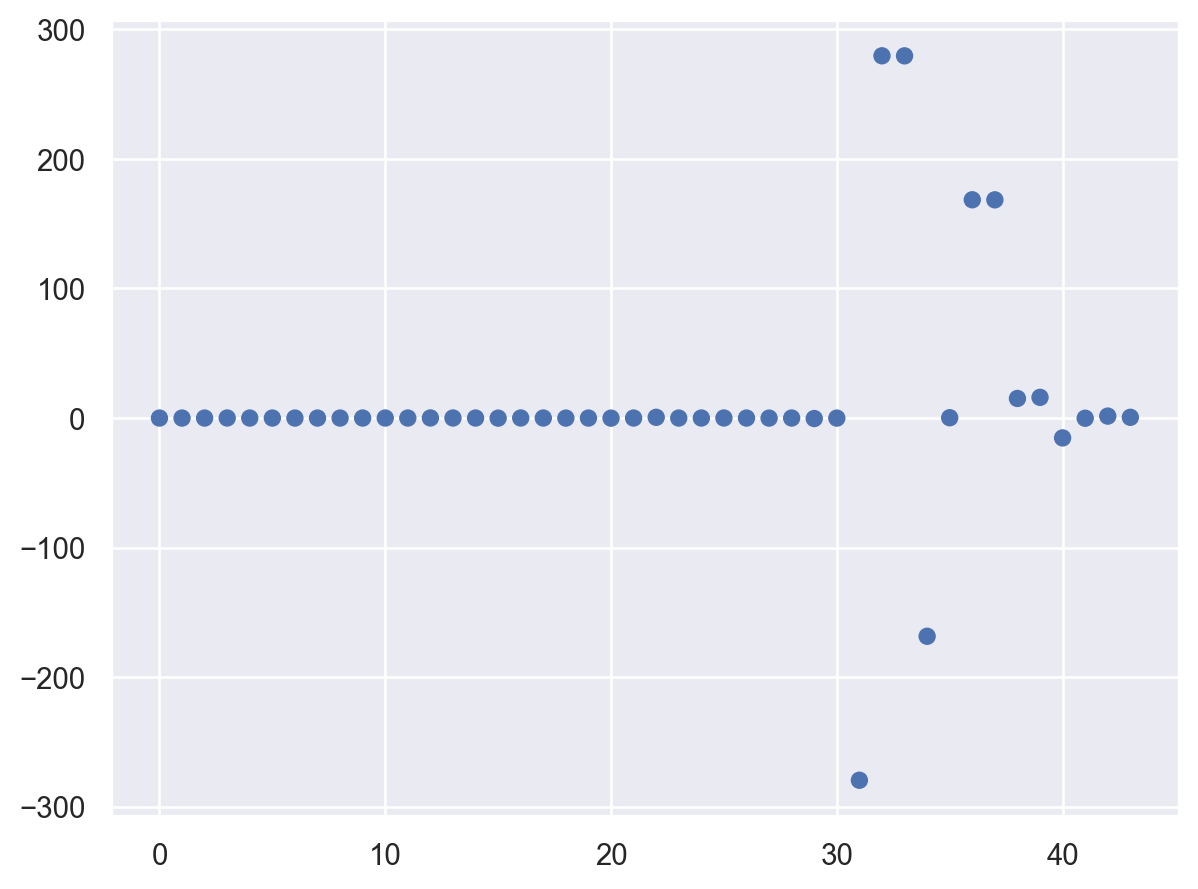

In [288]:
so.Plot(x = np.arange(len(modeloLineal.coef_)), y = modeloLineal.coef_).add(so.Dot())

Observando los coeficientes, hay coeficientes grandes que se cancelan, indicando posible colinealidad, lo que sugiere utilizar regresión Ridge. 

Veamos primero si las variables están en la misma escala.

In [289]:
X.max()

GP             41.00000
Min_per        98.00000
Ortg          834.00000
usg            50.00000
eFG           150.00000
TS_per        150.00000
ORB_per      1576.60000
DRB_per      1385.00000
AST_per       100.00000
TO_per        100.00000
FTM           312.00000
FTA           374.00000
FT_per          1.00000
twoPM         333.00000
twoPA         678.00000
twoP_per        1.00000
TPM           147.00000
TPA           394.00000
TP_per          1.00000
blk_per      1072.00000
stl_per       118.20000
ftr          1000.00000
porpag          8.65819
adjoe         678.94200
pfr           720.00000
year         2021.00000
pid         74254.00000
drtg          131.46100
adrtg         144.68500
dporpag         5.80053
stops         360.57200
bpm           685.31300
obpm          161.99500
dbpm          523.31900
gbpm          269.50800
mp             50.00000
ogbpm         225.48500
dgbpm          78.98550
oreb            5.93330
dreb           11.54550
treb           15.00000
ast            1

Vemos que hay mucha diferencia en las escalas de las variables. Para poder comparar mejor los coeficientes, escalamos todas la variables al intervalo [0,1].

¿Cómo aplicamos el escalamiento

$$
x_{\text{nuevo}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

en las columnas de un DataFrame? ($x_{\min}$ y $x_{\max}$ son el mínimo y máximo de cada columna.)

In [290]:
# Restamos primero el mínimos a todas las columnas, y verificamos.
X_sclaed = (X - X.min())
X_scaled.min()   # ¿Cuál esperamos que sea el resultado?

GP          0.0
Min_per     0.0
Ortg        0.0
usg         0.0
eFG         0.0
TS_per      0.0
ORB_per     0.0
DRB_per     0.0
AST_per     0.0
TO_per      0.0
FTM         0.0
FTA         0.0
FT_per      0.0
twoPM       0.0
twoPA       0.0
twoP_per    0.0
TPM         0.0
TPA         0.0
TP_per      0.0
blk_per     0.0
stl_per     0.0
ftr         0.0
porpag      0.0
adjoe       0.0
pfr         0.0
year        0.0
pid         0.0
drtg        0.0
adrtg       0.0
dporpag     0.0
stops       0.0
bpm         0.0
obpm        0.0
dbpm        0.0
gbpm        0.0
mp          0.0
ogbpm       0.0
dgbpm       0.0
oreb        0.0
dreb        0.0
treb        0.0
ast         0.0
stl         0.0
blk         0.0
dtype: float64

In [291]:
# Ahora dividimos las columnas por x_max - x_min
X_scaled = (X - X.min()) / (X.max() - X.min())
print(X_scaled.min())
print(X_scaled.max())

GP          0.0
Min_per     0.0
Ortg        0.0
usg         0.0
eFG         0.0
TS_per      0.0
ORB_per     0.0
DRB_per     0.0
AST_per     0.0
TO_per      0.0
FTM         0.0
FTA         0.0
FT_per      0.0
twoPM       0.0
twoPA       0.0
twoP_per    0.0
TPM         0.0
TPA         0.0
TP_per      0.0
blk_per     0.0
stl_per     0.0
ftr         0.0
porpag      0.0
adjoe       0.0
pfr         0.0
year        0.0
pid         0.0
drtg        0.0
adrtg       0.0
dporpag     0.0
stops       0.0
bpm         0.0
obpm        0.0
dbpm        0.0
gbpm        0.0
mp          0.0
ogbpm       0.0
dgbpm       0.0
oreb        0.0
dreb        0.0
treb        0.0
ast         0.0
stl         0.0
blk         0.0
dtype: float64
GP          1.0
Min_per     1.0
Ortg        1.0
usg         1.0
eFG         1.0
TS_per      1.0
ORB_per     1.0
DRB_per     1.0
AST_per     1.0
TO_per      1.0
FTM         1.0
FTA         1.0
FT_per      1.0
twoPM       1.0
twoPA       1.0
twoP_per    1.0
TPM         1.0
TPA      

**Escalamiento MinMax**

Escalamos las variables utilizando escalamiento MinMax.

La regresión lineal ordinaria es invariante por escalamiento lineal.

Esto quiere decir que si bien los coeficientes van a cambiar, las predicciones se van a mantener iguales.

El escalamiento no va a solucionar los problemas de colinealidad, pero nos permite comparar mejor los coeficientes.

Dado que solo queremos comparar coeficientes, no es necesario escalar la variable respuesta $y$.

In [292]:
# Ponemos todo en una instrucción
X_scaled = (X - X.min()) / (X.max() - X.min())

In [293]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X_scaled, y)

# Predicciones
y_pred = modeloLineal.predict(X_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53270
R cuadrado: 0.98841


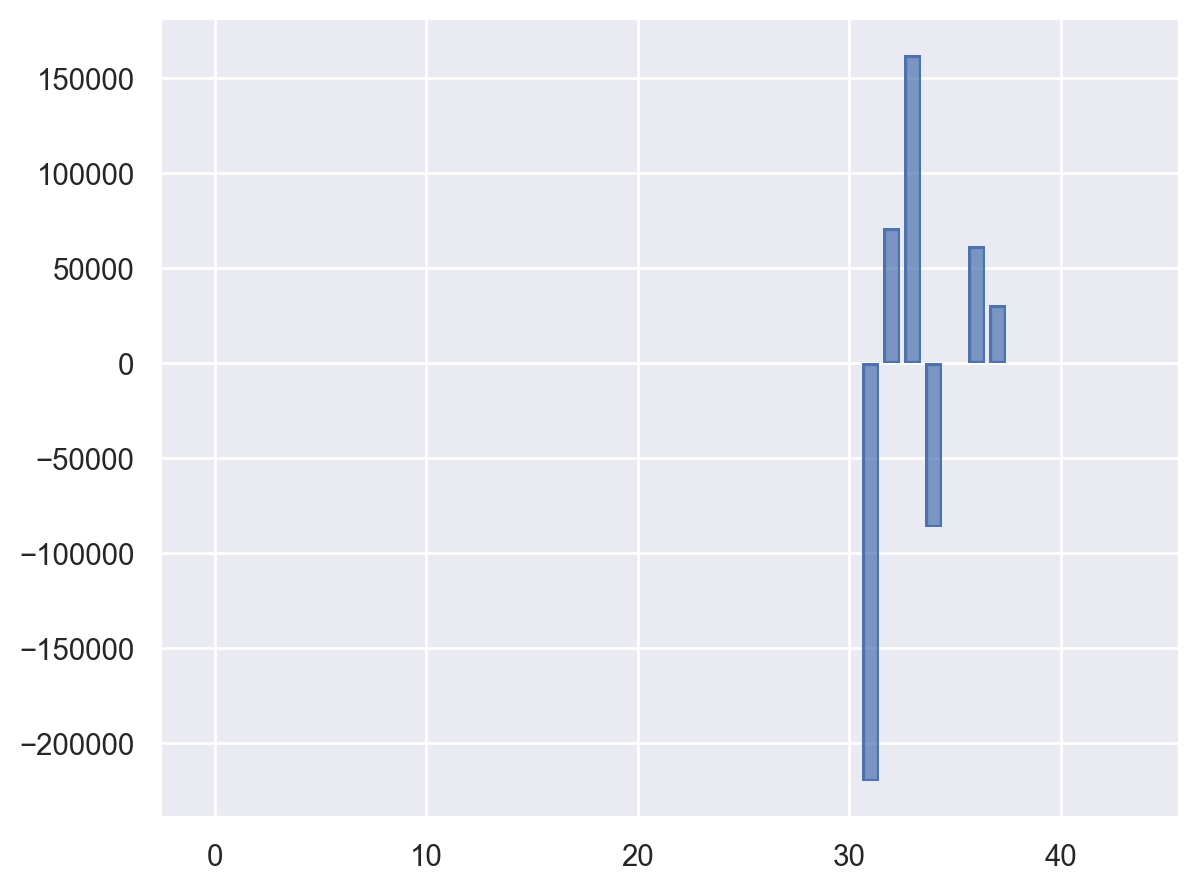

In [294]:
# Seguimos observando coeficientes enormes que se cancelan mutuamente.
so.Plot(x = np.arange(len(modeloLineal.coef_)), y = modeloLineal.coef_).add(so.Bar())

Los problemas de colinealidad son más evidentes ahora.

En base a lo observado, vamos a utilizar un modelo de regresión de Ridge.
Separamos en entrenamiento y testeo.

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [296]:
# Inicializamos el modelo lineal
modeloRidge = linear_model.Ridge(alpha = 1)  # Ejercicio: calcular alpha por validacion cruzada

# Entrenamiento
modeloRidge.fit(X_train, y_train)

# Predicciones
y_pred = modeloRidge.predict(X_train)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53394
R cuadrado: 0.98837


In [1]:
# Observamos los coeficientes
so.Plot(x = np.arange(len(modeloRidge.coef_)), y = modeloRidge.coef_).add(so.Bar())

NameError: name 'plt' is not defined

Redujimos el problema de coeficientes grandes que se anulan, pero todavía resulta difícil comparar los pesos de las distintas variables. 

Además en el modelo lineal Ridge penalizamos coeficientes grandes. Si las variables están a distinta escala, esto hace que penalicemos más a algunas variables que a otras.

En Regresión Ridge casi siempre es necesario escalar las variables.

Reescalamos todas las variables a [0,1].

Utilizamos ahora MinMaxScaler de sklearn para las transformaciones.
Esto permite calcular los parámetros de la transformación en el conjunto de entrenamiento y aplicarlo en el conjunto de testeo.

In [298]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas") # La última opción hace que nos devuelva un DataFrame

In [299]:
# fit_transform calcula los coeficientes de la transformación y la aplica.
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled.max()

GP          1.0
Min_per     1.0
Ortg        1.0
usg         1.0
eFG         1.0
TS_per      1.0
ORB_per     1.0
DRB_per     1.0
AST_per     1.0
TO_per      1.0
FTM         1.0
FTA         1.0
FT_per      1.0
twoPM       1.0
twoPA       1.0
twoP_per    1.0
TPM         1.0
TPA         1.0
TP_per      1.0
blk_per     1.0
stl_per     1.0
ftr         1.0
porpag      1.0
adjoe       1.0
pfr         1.0
year        1.0
pid         1.0
drtg        1.0
adrtg       1.0
dporpag     1.0
stops       1.0
bpm         1.0
obpm        1.0
dbpm        1.0
gbpm        1.0
mp          1.0
ogbpm       1.0
dgbpm       1.0
oreb        1.0
dreb        1.0
treb        1.0
ast         1.0
stl         1.0
blk         1.0
dtype: float64

In [300]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.Ridge(alpha = 1) 

# Entrenamiento
modeloLineal.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modeloLineal.predict(X_train_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.54396
R cuadrado: 0.98793


Ahora queremos ver los resultados en testeo, para eso transformamos los datos de testeo.

In [301]:
# Estará bien hacerlo así?
X_test_scaled = scaler.fit_transform(X_test)

In [302]:
# Predicciones
y_pred = modeloLineal.predict(X_test_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 1.71347
R cuadrado: 0.87934


.

.

.

.

.

.

.

.



No funciona bien porque aplicamos una transformación distinta, los valores de x_min y x_max se recalcularon.

La forma correcta es usar solo transform, sin "fitear" nuevamente los parametros del ajuste.

In [303]:
# Tenemos que fittear en entrenamiento y aplicar esa transformación a los datos de testeo
scaler.fit(X_train)   # Primero fiteamos (este paso no es necesario si ya hicimos fit_transform en X_train)
X_test_scaled = scaler.transform(X_test)  # Luego transformamos

In [304]:
# Predicciones
y_pred = modeloLineal.predict(X_test_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53816
R cuadrado: 0.98810


Ahora sí obtenemos buenas predicciones!

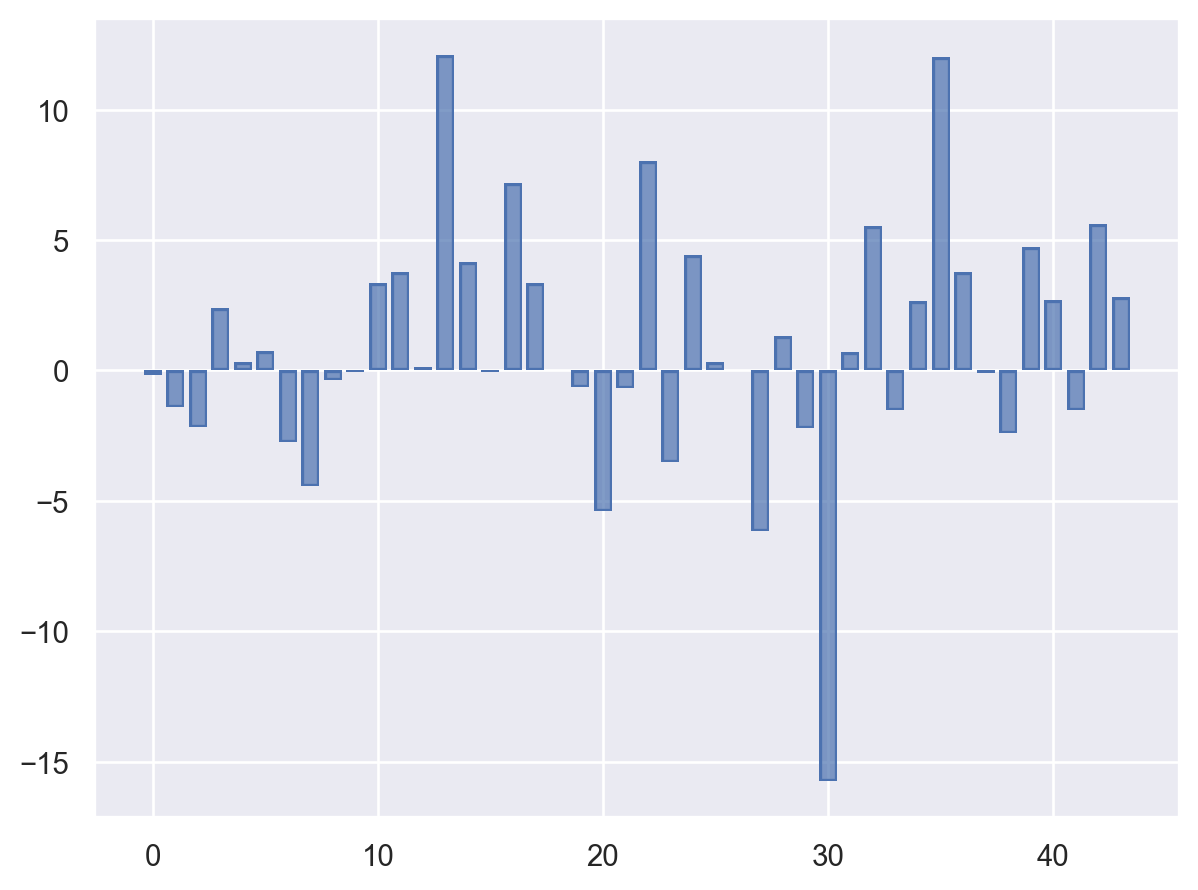

In [305]:
# Graficamos los coeficientes
so.Plot(x = np.arange(len(modeloLineal.coef_)), y = modeloLineal.coef_).add(so.Bar())

Vemos que ahora los coeficientes tienen rangos similares.

## Ejemplo 2: One Hot Encoding

Veamos otro ejemplo ahora donde queremos aplicar en la etapa de preprocesamiento One Hot Encoding a alguna variable categórica.

In [306]:
penguins = sns.load_dataset("penguins").dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Ya vimos que para poder predecir la profundidad del pico en función de la profundidad, debemos agregar la interacción con la especie.

Supongamos que queremos construir un modelo utilizando todos los datos de la base excepto los últimos 5 datos.

Y luego aplicar el modelo a esos 5 datos.

In [307]:
penguins_train = penguins.iloc[:-5,:]
penguins_train.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
332,Gentoo,Biscoe,43.5,15.2,213.0,4650.0,Female
333,Gentoo,Biscoe,51.5,16.3,230.0,5500.0,Male
334,Gentoo,Biscoe,46.2,14.1,217.0,4375.0,Female
335,Gentoo,Biscoe,55.1,16.0,230.0,5850.0,Male
337,Gentoo,Biscoe,48.8,16.2,222.0,6000.0,Male


In [308]:
penguins_test = penguins.iloc[-5:,:]
penguins_test.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


In [309]:
formula = 'bill_depth_mm ~ bill_length_mm * species'
y_train, X_train =  Formula(formula).get_model_matrix(penguins_train)
X_train.head()

,Intercept,bill_length_mm,species[T.Chinstrap],species[T.Gentoo],bill_length_mm:species[T.Chinstrap],bill_length_mm:species[T.Gentoo]
0,1.0,39.1,0,0,0.0,0.0
1,1.0,39.5,0,0,0.0,0.0
2,1.0,40.3,0,0,0.0,0.0
4,1.0,36.7,0,0,0.0,0.0
5,1.0,39.3,0,0,0.0,0.0


In [310]:
# Ajustamos el modelo

# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression()

# Entrenamiento
modeloLineal.fit(X_train, y_train)

# Predicciones en entrenamiento
y_pred = modeloLineal.predict(X_train)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.95054
R cuadrado: 0.76442


In [311]:
# Calculamos la perfomance en las predicciones

# Funcionará esto??
formula = 'bill_depth_mm ~ bill_length_mm * species'
y_test, X_test =  Formula(formula).get_model_matrix(penguins_test)

In [312]:
# Predicciones en testeo
y_pred = modeloLineal.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- bill_length_mm:species[T.Chinstrap]
- bill_length_mm:species[T.Gentoo]
- species[T.Chinstrap]
- species[T.Gentoo]


In [313]:
# Veamos si tenemos las mismas variables...
X_train.head()

,Intercept,bill_length_mm,species[T.Chinstrap],species[T.Gentoo],bill_length_mm:species[T.Chinstrap],bill_length_mm:species[T.Gentoo]
0,1.0,39.1,0,0,0.0,0.0
1,1.0,39.5,0,0,0.0,0.0
2,1.0,40.3,0,0,0.0,0.0
4,1.0,36.7,0,0,0.0,0.0
5,1.0,39.3,0,0,0.0,0.0


In [314]:
# Como X_test tiene pinguinos solo de la isla Biscoe, agregar la interacción con la isla no agrega nuevas variables.
X_test.head() 

,Intercept,bill_length_mm
338,1.0,47.2
340,1.0,46.8
341,1.0,50.4
342,1.0,45.2
343,1.0,49.9


In [315]:
# Tenemos que aplicar las transformaciones que se hicieron en entrenamiento al conjunto de testeo.

# Para eso en Formulaci podemos usar model_spec (las especificaciones del modelo).
ms_X = X_train.model_spec
ms_y = y_train.model_spec

In [320]:
# Ahora en vez de generar la matrices a partir de la fórmula, la generamos a partir de las especificaciones
X_test = ms_X.get_model_matrix(penguins_test)
y_test = ms_y.get_model_matrix(penguins_test)

In [321]:
# Ahora sí podemos predecir

# Predicciones en testeo
y_pred = modeloLineal.predict(X_test)

y_pred

array([[14.9272153 ],
       [14.84485842],
       [15.58607036],
       [14.51543088],
       [15.48312426]])

In [322]:
y_test

,bill_depth_mm
338,13.7
340,14.3
341,15.7
342,14.8
343,16.1
